# CRIC Autoplier Survival Analysis 

In [ ]:
import os
import pickle
#import autoplier as ap
import autoplier.model as ap
import autoplier.plot as plot

import pandas as pd
import numpy as np

#from functools import reduce
#from scipy.stats import zscore

from tensorflow.keras.callbacks import EarlyStopping, LambdaCallback
from tensorflow.keras.models import load_model

from sklearn.preprocessing import Normalizer, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression, Lasso
from sklearn.model_selection import GridSearchCV

from sksurv.nonparametric import kaplan_meier_estimator
from sksurv.linear_model import CoxPHSurvivalAnalysis
from sksurv.compare import compare_survival
from sksurv.metrics import concordance_index_censored

import matplotlib.pyplot as plt

# Setup

In [57]:
# seed
seed = 3306059

# data path
datadir = os.path.join('data')

#results path
outdir = os.path.join('results')

#APRT quantile cutoff
APRT_quant = 2/3


In [58]:
datadir = os.path.join('data')
datadir

'data'

 # Formatting

In [59]:
clindf=pd.read_csv(os.path.join(datadir, 'preprocessing_results.csv'), sep=',')

#make patientid an integer in clindf an make it the index
clindf['patientid'] = clindf['patientid'].astype(int)
clindf = clindf.set_index('patientid')

#log transform urine_albumin to urine creatinine ratio
clindf['log2acr'] = np.log2(clindf['urine_albumin_v3y0']+1) - np.log2(clindf['urine_creatinine_v3y0']+1)

#display(clindf.head())

In [60]:
metadf=pd.read_csv(os.path.join(datadir, 'CRIC_samplemetadata.csv'), sep=',', header=None)

#split the patientids and visit number in col 1 in omics sample metadata into a list
#metadf[1] = metadf[1].str.split("_")
metadf = pd.concat([metadf, pd.DataFrame(metadf[1].str.split("_").tolist(), columns=['patientid', 'visit'])], axis=1)

#display(metadf.head())

In [61]:
#get omics data
omdf=pd.read_csv(os.path.join(datadir, 'CRIC_creatinine_normalized_data.csv'), sep=',', header=None)

#assert metadata rows equal omics data columns
assert(len(metadf.index)==len(omdf.columns))

#rename omdf columns with id_visit numbers in metadata
omdf.rename(columns=dict(zip(omdf.columns, metadf[1])), inplace=True)

#display(omdf)

In [62]:
#get membership matrix
membdf=pd.read_csv(os.path.join(datadir, 'membership.csv'), sep=',')

#shift the ion column in membership data to start counting from 0 not 1
membdf['ion'] = membdf['ion'].astype(int)-1

#assert ions in membership matrix all exist as rows in omics data
assert(membdf.ion.isin(omdf.index).all())

#display(membdf)

In [63]:
#format omics data

#remove ions in omics data not present in the membership matrix
omdf = omdf.loc[omdf.index.isin(membdf.ion)]

#init temp omics df indexed with with membership matrix name-ion pairs
nameionpairs = membdf.name + " " + membdf.ion.astype(str)
omics = pd.DataFrame(index=nameionpairs, columns=omdf.columns)

#loop over rows in membership matrix
for idx, row in membdf.iterrows():
    #assign omics by omdf index
    omics.iloc[idx, :] = omdf.loc[omdf.index == row.ion]
    
#remove inf
omics = omics.replace( np.inf , np.nan )

#replace NA with zeros
omics = omics.replace(np.nan, 0)

#log+1 transform
omics = omics.transform(lambda x: np.log(x.astype(float)+1))
#omics = np.log(omics+1)

#unit scale omics standard deviation
#omics = omics.apply(zscore)
#omics = (omics - omics.mean())/omics.std()
#omics = omics / omics.std()

#assert all values are complete and positive
assert(not omics.isnull().any(axis=None))
assert(np.all(omics>0))

#overwrite omdf with temp omics
omdf = omics

#display(len(membdf.ion.unique()))
#display(omdf)

In [64]:
with open('data/eqiv_pathways.pkl', 'rb') as handle:
    equiv_pathways_dict = pickle.load(handle)

# Partition Data

In [65]:
# demonstrate groups cannot be predicted by omics
#(todo)

In [66]:
#  - - - - - - Partition Data  - - - - - -
#get unique patient ids
patientids = metadf.patientid.dropna().unique()

#explicitly drop 'N.A.' ids
patientids= np.delete(patientids, patientids=='N.A.')

#partition 1/5 validation set by patient ids
validids = np.random.choice(patientids, size=len(patientids)//5, replace=False)
trainids = patientids[~np.isin(patientids, validids)]

#get Xtrain and Xvalid with samples in rows and omics in columns
Xtrain = omdf.loc[:, np.isin(metadf.patientid, trainids)].T
Xvalid = omdf.loc[:, np.isin(metadf.patientid, validids)].T

#Select covariates
covariates = ['mu_egfr_rate', 'age_integer_v3y0', 'sex_v3y0', 'race_ethnicity_cat2_v3y0',
              'map_v3y0','hemoglobin_a1c_v3y0','waist_v3y0',
              'log2acr', 'egfr_cric_v3y0']

#select all albuminuria patients
clinred_full = clindf.loc[clindf['albuminuria_v3y0']>0, covariates]
clinred_normo = clindf.loc[clindf['albuminuria_v3y0']==1, covariates]
clinred_normomicro = clindf.loc[clindf['albuminuria_v3y0']<3, covariates]


#display(clinred_full)
#display(clinred_normo)
#display(clinred_normomicro)


# Omics to pathway transformation

In [67]:
#assert all omics are in the membership data
missingomics =  Xtrain.columns[~Xtrain.columns.isin(membdf.name + " " + membdf.ion.astype(str))]
if len(missingomics)>0:
    # WARNING: missing omics
    print("the following omics were not found in the membership data.")
    print(missingomics)
assert(len(missingomics)==0)

In [68]:
#get the omics labels (Omega) for the columns in X
bigomega = Xtrain.columns
#print(bigomega)

#get the known pathways (Pi)
bigpi = membdf.columns[4:]
#print(bigpi)

In [69]:
#format membership matrix
Cmat = membdf[bigpi]
Cmat.index = bigomega
#transpose membership matrix so pathways are in rows and omics are in columns
Cmat = Cmat.T
#display(Cmat)

In [70]:
#--- dump formatted xtrain, xvalid, and cmat
#Xtrain.to_csv(os.path.join(outdir, 'Xtrain.csv'))
#Xvalid.to_csv(os.path.join(outdir, 'Xvalid.csv'))
#Cmat.to_csv(os.path.join(outdir, 'Cmat.csv'))
#clindf.to_csv(os.path.join(outdir, 'clinical.csv'), index=True)

# Autoplier
Autoplier is an unsupervised dimension reduction method that transforms the longitudinal metabolomics data into the pathway representation.

## Setup

In [71]:
#fixed hyperparameters
maxepoch = 5000
patience = 10
batch_size= None
valfrac = .3
learning_rate = .001
decay_rate= learning_rate/maxepoch
regval = 5e-3

In [72]:
# Autoplier callbacks
callbacks = [
        #early stopping - to mitigate overfitting
        EarlyStopping(patience=patience, monitor='val_loss'),
        #monitor umatrix sparsity
        ]

## Estimate number of latent variables

In [73]:
#  - - - - - - Init guess data compressibility  - - - - - -
# Full dof PCA for all data
pca = PCA(random_state = seed) #do not define number of PCs

#transform omics into pathway representation
Xtilde = np.dot(Xtrain, Cmat.T.to_numpy())

#fit pca on the training data
X_pca = pca.fit_transform(Xtilde)

# compute total variation explained
totvar = sum(pca.explained_variance_)
cum_var = np.cumsum(pca.explained_variance_)/totvar

#show variation explained (diagnostic only)
nPC = 50
print(cum_var[0:nPC])

#choose nLV = whichever is less: 2 times the number of PCs that explain 99% of variation (3 sigmas), or 90% of pathways
nLV = np.min([len(np.where(cum_var<=.99)[0])*2, len(Cmat.index)*.90]).astype(int)
print("Number of Latent Variables is "+ str(nLV))

[0.71644284 0.83125305 0.8692016  0.89713823 0.9127212  0.9267069
 0.93836397 0.94699799 0.95386982 0.96028079 0.96590013 0.97049669
 0.97471538 0.97770966 0.98010243 0.98226641 0.98424661 0.9859141
 0.98753152 0.98887864 0.98998161 0.9909476  0.99184716 0.9926543
 0.99339638 0.99405065 0.99460922 0.99513615 0.99562705 0.996049
 0.99642802 0.99676621 0.99705928 0.99732591 0.99758725 0.99783614
 0.9980324  0.99821758 0.99840186 0.99856481 0.99872239 0.99885275
 0.99897899 0.99909077 0.99919061 0.99928248 0.99936618 0.99944373
 0.99950684 0.99956571]
Number of Latent Variables is 42


## Estimate regularization constant

In [74]:
# --- init guess target sparsity based on size LV matrix (bigPI x nLV) ---
# say the LVs are non trivial with 10 major Pathway components in each 
# 1- (nLV * 10) / (nLV * npathways)
target_sparsity = 1 - (10/len(bigpi))
#print(len(bigpi))
print("targetsparsity is " + str(target_sparsity))

targetsparsity is 0.9107142857142857


In [75]:

print("L1 regularization value is " + str(regval))

L1 regularization value is 0.005


## Train autoplier

In [76]:
# unsupervised training scheme
def train_autoplier(X, pathways, n_LVs, regval):
    #set seed
    ap.set_seed_(seed)

    #create model
    model = ap.autoPLIER(n_LVs, regval=regval, learning_rate=learning_rate)
    #model = ap.autoPLIER(n_LVs, regval = 0, learning_rate= learning_rate)
    
    #set normalizer
    #ap.scaler = Normalizer(norm='l1', copy=True)
    
    #fit model
    history = model.fit(X, pathways, callbacks, batch_size=batch_size, maxepoch=maxepoch, verbose=1, valfrac=valfrac)
    
    # compute latent variables
    Z = model.transform(X, pathways)
    
    # diagnostic - print sparsity
    print("Trained Model Sparsity is " +str(ap.sparsity_epsilon(model.components_decomposition_, 1.0E-4)))
    
    #return latent variables and trained model
    return Z, model, history

In [77]:
#where to save autoplier model
modelpath = 'models/cric_autoplier'

#train new autoplier model
Z, model, history = train_autoplier(Xtrain, Cmat, nLV, regval)
#model.save(modelpath)



#model.plot
#plot.plot_top_pathways([zmap[lv]], 5, (5, 2.5), mod)
##load saved autoplier model
#model = tf.keras.models.load_model(modelpath)
## compute latent variables
#Z = model.transform(Xtrain, Cmat)

#print(Z)

Epoch 1/5000
106/106 [==============================] - 0s 2ms/step - loss: 686458.2500 - magz: 522111744.0000 - val_loss: 87321.8047 - val_magz: 262610368.0000
Epoch 2/5000
106/106 [==============================] - 0s 2ms/step - loss: 39325.6289 - magz: 202792160.0000 - val_loss: 15544.8203 - val_magz: 159820784.0000
Epoch 3/5000
106/106 [==============================] - 0s 2ms/step - loss: 8921.8555 - magz: 142136656.0000 - val_loss: 4790.5942 - val_magz: 126313704.0000
Epoch 4/5000
106/106 [==============================] - 0s 2ms/step - loss: 3096.5452 - magz: 119352552.0000 - val_loss: 1912.7899 - val_magz: 111696704.0000
Epoch 5/5000
106/106 [==============================] - 0s 2ms/step - loss: 1321.3359 - magz: 108739992.0000 - val_loss: 879.6977 - val_magz: 104349984.0000
Epoch 6/5000
106/106 [==============================] - 0s 2ms/step - loss: 632.1342 - magz: 103157856.0000 - val_loss: 439.4529 - val_magz: 100303016.0000
Epoch 7/5000
106/106 [============================

# Association of Latent variables with eGFR decline
A linear regression classifier with optional adjustment for clinical variables. Standard scale  predictors to derermine strongest pathway predictors.

In [78]:
#import statsmodels.api as sm

# define classifier
def classify(mod, Xtrain, Cmat, clin, clinadj=True, benchmark=False):
    
    #select baseline samples
    X = Xtrain.loc[Xtrain.index.str.contains("_V3Y0"), :]

    #remove visit number from index
    X.index = np.array(X.index.str.split("_").tolist())[:,0].astype(int)
    X.index.rename("patientid", inplace=True)
    
    #select patients in the clinical variables
    X = X[X.index.isin(clin.index)]

    #drop duplicate patientids
    X = X[~X.index.duplicated(keep='first')]
 
    #get clinical variables for every patient in X
    clinx = clin.loc[X.index]

    #confirm equal number of samples
    assert(len(X.index)==len(clinx.index))
       
    #use mean eGFR rate as outcome
    y=clinx['mu_egfr_rate']
    
    #drop egfr rate in clinical variables
    clinx.drop(columns=['mu_egfr_rate'], inplace=True)
 
    #encode categorical sex clinical variable
    le = LabelEncoder()
    le.fit(clinx['sex_v3y0'].unique())
    clinx['sex_v3y0'] = le.transform(clinx['sex_v3y0'])

    #encode categorical race clinical variable
    le = LabelEncoder()
    le.fit(clinx['race_ethnicity_cat2_v3y0'].unique())
    clinx['race_ethnicity_cat2_v3y0'] = le.transform(clinx['race_ethnicity_cat2_v3y0'])
      
    #transform Xtrain data into latent representation
    Z = mod.transform(X, Cmat)
    
    ##Filter latent variables that are not significantly associated with outcome
    #    def get_line_pval(X, Y, sex_col):
    #    name = X.name
    #    X = pd.concat([X, sex_col], axis=1)
    #    X = sm.add_constant(X)
    #    line = sm.OLS(Y, X).fit()
    #    return line.pvalues[name]

    #varying columns
    #varcols = (Z != Z.iloc[0]).any()
    #print("-----")
    #print(Z.columns[varcols])
    
    #get map of original columns
    #zmap = [idx for idx, ibool in enumerate(varcols) if ibool]
    
    #print(Z.shape[1])
    #print(zerocols)
    #print(np.sum(zerocols))
    #print(len(zmap))
    #print(zmap)
    
    #remove constant columns
    #Z = Z.loc[:, varcols]

    #get number of LVs
    nLV = Z.shape[1]
    #print(nLV)
    #stop
    
    #log and Zscore latent variables
    #Z = np.log(Z+1)
    #Z = np.subtract(Z, np.mean(Z, axis=0))
    #Z = np.divide(Z, np.std(Z, axis=0))
    
    #add clinical variables
    if clinadj:
        Z = Z.merge(clinx, on='patientid')
        
    #train clinical only model
    if benchmark:
        Z = clinx
    
    #gurantee column names are all strings
    Z.columns = Z.columns.astype(str)
    
    #Latent variable PCA represenation
    pca = PCA(n_components=2, random_state = seed)
    Z_pca = pca.fit_transform(Z)
    
    #visualize case/ctrl patients projected on first 2 prinicpal components
    fig = plt.figure()
    ax = fig.add_subplot()
    scatter = ax.scatter(Z_pca[:,0], Z_pca[:,1], c = y, cmap='plasma')
    fig.colorbar(scatter)
    # produce a legend with the unique colors from the scatter
    #legend1 = ax.legend(*scatter.legend_elements(), loc="upper right", title="fast progressors")
    #ax.add_artist(legend1)

    #ax.legend()
    plt.show()
    
    #grid search parameters
    PARAMETERS = {
        'alpha': [
        0.00001,
        0.00002,
        0.00005,
        0.0001,
        0.0002,
        0.0005,
        0.001,
        0.002,
        0.005,
        0.010,
        0.020,
        0.050,
        0.100,
        0.200,
        0.500,    
        1.000,
        2.000,
        5.000,    
        10.000,
        ]
    }
    MAX_ITER = 200000

    #base_model = LogisticRegression(penalty='l1', 
    #                              solver='liblinear',
    #                              #class_weight='balanced',
    #                              random_state=seed)
    #clf = GridSearchCV(base_model, PARAMETERS, scoring='roc_auc')
    #clf = GridSearchCV(base_model, PARAMETERS, scoring='f1')
    #clf = GridSearchCV(base_model, PARAMETERS, scoring='neg_log_loss')

    #define base model and how to gridsearch
    base_model = Lasso(max_iter=MAX_ITER, random_state=seed)
    clf = GridSearchCV(base_model, PARAMETERS, scoring='neg_root_mean_squared_error')

    #do gridsearch
    clf.fit(Z, y)
    best_params = max(
        zip(
            clf.cv_results_['param_alpha'], 
            clf.cv_results_['mean_test_score']
        ),
        key=lambda x: x[1]
    )
    best_alpha = best_params[0]
    print('Mean test scores:')
    print(clf.cv_results_['mean_test_score'])
    print("Best alpha chosen: ", best_alpha)
    
    
    #Train final model with best hyperparameter
    #final_model = LogisticRegression(penalty='l1', 
    #                              solver='liblinear', 
    #                              #class_weight='balanced',
    #                              random_state=seed,
    #                              C=best_C)
    #final_model.fit(Z, y)
    final_model = Lasso(alpha=best_alpha, max_iter=MAX_ITER, random_state=seed)
    final_model.fit(Z, y)
    print("final model score", final_model.score(Z, y))
    
    if not benchmark:
    
        #get coefficients
        coeffs = final_model.coef_
        coeffs = coeffs.squeeze()
        #print(coeffs)

        #get only LV coeffs
        coeffs = coeffs[:nLV]

        #get the largest and smallest LVs 
        topN = 5
        largest = coeffs.argsort()[-topN:]
        smallest = coeffs.argsort()[:topN]
                

        largest_vals = [coeffs[x] for x in largest]
        smallest_vals = [coeffs[x] for x in smallest]

        #limit to non-zero coeffs
        nlarge = len([i for i in largest_vals if i > 0])  
        nsmall = len([i for i in smallest_vals if i < 0])  

        #print any large LVs
        if nlarge>0:
            largest = largest[0:nlarge]
            largest_vals = largest_vals[0:nlarge]
            print("LVs associated with classification of rapid progressors :" )
            print(largest)
            print(largest_vals)
            #print(np.array(zmap)[largest])
            for lv in largest:
                plot.plot_top_pathways([lv], 5, (5, 2.5), mod)
                #plot.plot_top_pathways([zmap[lv]], 5, (5, 2.5), mod)
                #plt.title(f'LV {zmap[lv]}')
                plt.show()
        else:
            print("No LVs are associated with classification of rapid progressors!")

        #print any small LVs
        if nsmall>0:
            smallest = smallest[0:nsmall]
            smallest_vals = smallest_vals[0:nsmall]
            print("LVs associated with classification of slow progressors :" )
            print(smallest)
            print(smallest_vals)
            for lv in smallest:
                plot.plot_top_pathways([lv], 5, (5, 2.55), mod)
                #plot.plot_top_pathways([zmap[lv]], 5, (5, 2.55), mod)
                #plt.title(f'LV {zmap[lv]}')
                plt.title(f'LV {lv}')
        else:
            print("No LVs are associated with classification of slow progressors!")

    return final_model, Z, y

# Full cohort analysis

## benchmark model

12/12 [==============================] - 0s 760us/step


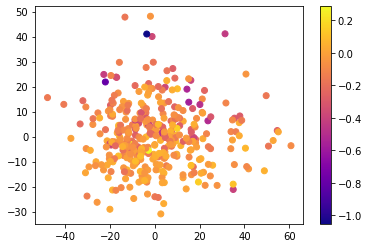

Mean test scores:
[-0.11924377 -0.11924096 -0.11923255 -0.11921867 -0.11919142 -0.11911359
 -0.11903738 -0.11898504 -0.11890946 -0.11886874 -0.11898396 -0.11986694
 -0.12332295 -0.13418987 -0.1399859  -0.14290614 -0.14290614 -0.14290614
 -0.14290614]
Best alpha chosen:  0.01
final model score 0.34012253902999456


In [79]:
fullcohort_model_clin, Z_fullcohort_clin, y_fullcohort_clin = classify(model, Xtrain, Cmat, clinred_full, benchmark=True)




## Top latent variables for predicting rapid eGFR decline unadjusted

12/12 [==============================] - 0s 1ms/step


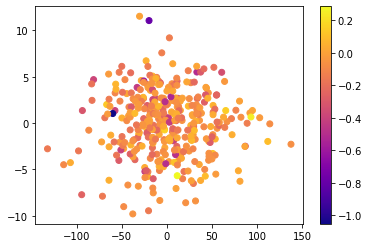

/Users/rabiul/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.536e-01, tolerance: 5.565e-04
  model = cd_fast.enet_coordinate_descent(
/Users/rabiul/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.191e-02, tolerance: 5.761e-04
  model = cd_fast.enet_coordinate_descent(
/Users/rabiul/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularis

Mean test scores:
[-0.14437436 -0.14426546 -0.1438887  -0.14364625 -0.14329868 -0.14336358
 -0.14325799 -0.14355408 -0.14257026 -0.14164522 -0.14219742 -0.14292958
 -0.14329472 -0.14321896 -0.14290614 -0.14290614 -0.14290614 -0.14290614
 -0.14290614]
Best alpha chosen:  0.01
final model score 0.08677805434222885
LVs associated with classification of rapid progressors :
[10 41 15]
[0.0, 0.0, 0.00019280403]


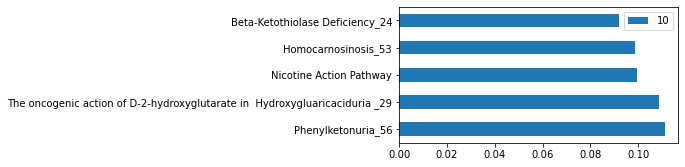

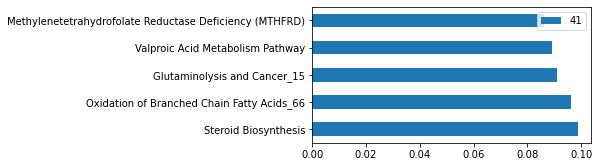

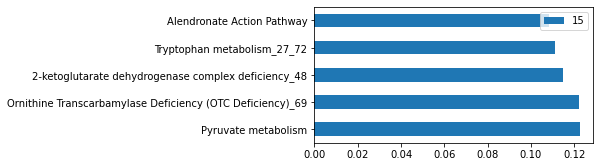

LVs associated with classification of slow progressors :
[26]
[-0.028007636]


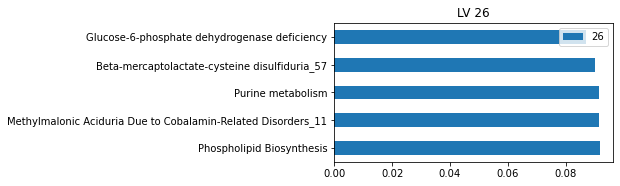

In [80]:
fullcohort_model_unadj, Z_fullcohort_unadj, y_fullcohort_unadj = classify(model, Xtrain, Cmat, clinred_full, clinadj=False)

## Top latent variables for predicting rapid eGFR decline with adjustment for clinical variables

12/12 [==============================] - 0s 770us/step


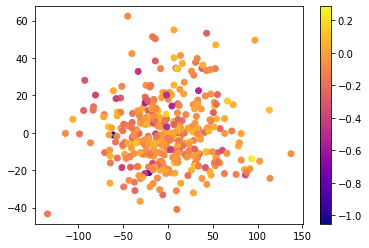

/Users/rabiul/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.598e-01, tolerance: 5.565e-04
  model = cd_fast.enet_coordinate_descent(
/Users/rabiul/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.411e-01, tolerance: 5.761e-04
  model = cd_fast.enet_coordinate_descent(
/Users/rabiul/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularis

Mean test scores:
[-0.13325386 -0.13305401 -0.13248023 -0.13159939 -0.13018682 -0.12783466
 -0.12617837 -0.12335695 -0.12119949 -0.1199762  -0.11951563 -0.12052864
 -0.12390141 -0.13448052 -0.1399859  -0.14290614 -0.14290614 -0.14290614
 -0.14290614]
Best alpha chosen:  0.02
final model score 0.3373961413730451
LVs associated with classification of rapid progressors :
[17]
[0.0]


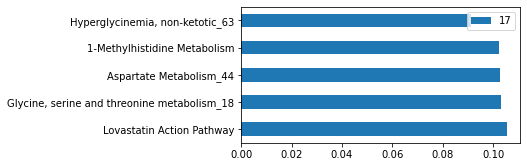

LVs associated with classification of slow progressors :
[6]
[-0.0009743887792612236]


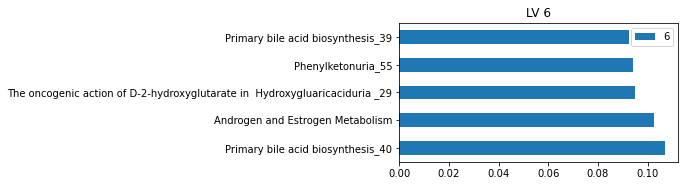

In [81]:
fullcohort_model, Z_fullcohort, y_fullcohort = classify(model, Xtrain, Cmat, clinred_full, clinadj=True)

# Normoalbuminuria group analysis

## benchmark model

4/4 [==============================] - 0s 1ms/step


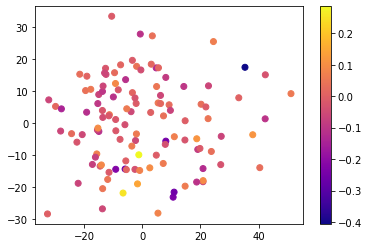

Mean test scores:
[-0.09403253 -0.09402536 -0.09400394 -0.0939711  -0.09391192 -0.09374277
 -0.09351615 -0.09323122 -0.09277173 -0.09299126 -0.09385218 -0.09362204
 -0.09286913 -0.09263406 -0.09258263 -0.09258263 -0.09258263 -0.09258263
 -0.09258263]
Best alpha chosen:  0.5
final model score 0.0


In [82]:
normo_model_clin, Z_normo_clin, y_normo_clin = classify(model, Xtrain, Cmat, clinred_normo, benchmark=True)




## Top latent variables for predicting rapid eGFR decline unadjusted

4/4 [==============================] - 0s 1ms/step


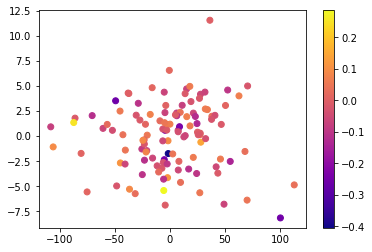

/Users/rabiul/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.545e-02, tolerance: 6.452e-05
  model = cd_fast.enet_coordinate_descent(
/Users/rabiul/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.356e-01, tolerance: 8.276e-05
  model = cd_fast.enet_coordinate_descent(
/Users/rabiul/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularis

Mean test scores:
[-0.12829256 -0.12736584 -0.12496019 -0.12205019 -0.11667675 -0.10770095
 -0.1023986  -0.09886174 -0.09513519 -0.0941002  -0.09280645 -0.09317736
 -0.09288908 -0.09258263 -0.09258263 -0.09258263 -0.09258263 -0.09258263
 -0.09258263]
Best alpha chosen:  0.2
final model score -4.440892098500626e-16
No LVs are associated with classification of rapid progressors!
No LVs are associated with classification of slow progressors!


In [83]:
normo_model_unadj, Z_normo_unadj, y_normo_unadj = classify(model, Xtrain, Cmat, clinred_normo, clinadj=False)

## Top latent variables for predicting rapid eGFR decline with adjustment for clinical variables

4/4 [==============================] - 0s 1ms/step


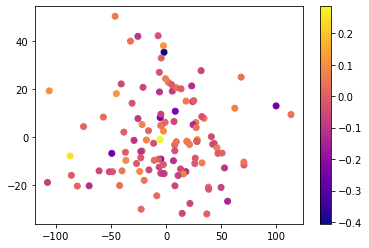

/Users/rabiul/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.586e-02, tolerance: 6.452e-05
  model = cd_fast.enet_coordinate_descent(
/Users/rabiul/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.937e-02, tolerance: 8.276e-05
  model = cd_fast.enet_coordinate_descent(
/Users/rabiul/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularis

Mean test scores:
[-0.13577027 -0.13452495 -0.13156505 -0.12733324 -0.12109037 -0.11033864
 -0.10325725 -0.09968    -0.09695517 -0.09562439 -0.0940966  -0.09408707
 -0.09316324 -0.09263406 -0.09258263 -0.09258263 -0.09258263 -0.09258263
 -0.09258263]
Best alpha chosen:  0.5
final model score 0.0
No LVs are associated with classification of rapid progressors!
No LVs are associated with classification of slow progressors!


In [84]:
 normo_model, Z_normo, y_normo = classify(model, Xtrain, Cmat, clinred_normo, clinadj=True)

# Normo and Micro albuminuria group analysis

## benchmark model

8/8 [==============================] - 0s 795us/step


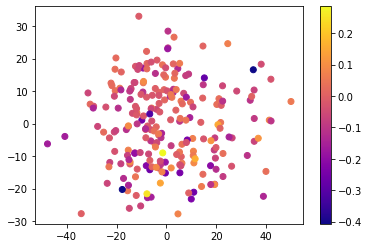

Mean test scores:
[-0.09165959 -0.0916594  -0.09165889 -0.09165829 -0.09165745 -0.09165865
 -0.09168906 -0.09183789 -0.09202967 -0.09231202 -0.09263867 -0.09574726
 -0.0963707  -0.09694383 -0.09694383 -0.09694383 -0.09694383 -0.09694383
 -0.09694383]
Best alpha chosen:  0.0002
final model score 0.15042174640205708


In [85]:
normomicro_model_clin, Z_normomicro_clin, y_normomicro_clin = classify(model, Xtrain, Cmat, clinred_normomicro, benchmark=True)




## Top latent variables for predicting rapid eGFR decline unadjusted

8/8 [==============================] - 0s 783us/step


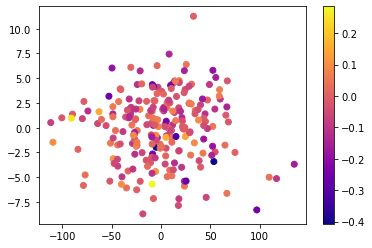

/Users/rabiul/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.241e-01, tolerance: 1.627e-04
  model = cd_fast.enet_coordinate_descent(
/Users/rabiul/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.287e-01, tolerance: 1.623e-04
  model = cd_fast.enet_coordinate_descent(
/Users/rabiul/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularis

Mean test scores:
[-0.10917474 -0.10880505 -0.10792316 -0.10705097 -0.10543605 -0.10215102
 -0.0998627  -0.09814342 -0.09612951 -0.09628208 -0.09621497 -0.09641662
 -0.09714567 -0.09694383 -0.09694383 -0.09694383 -0.09694383 -0.09694383
 -0.09694383]
Best alpha chosen:  0.005
final model score 0.08859272748199054
LVs associated with classification of rapid progressors :
[24 35 17 39  7]
[0.00024663785, 0.0010374903, 0.001131226, 0.0015268293, 0.010082694]


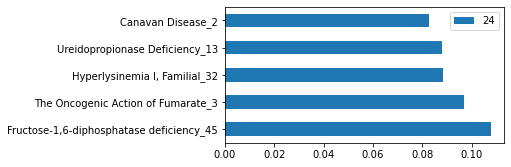

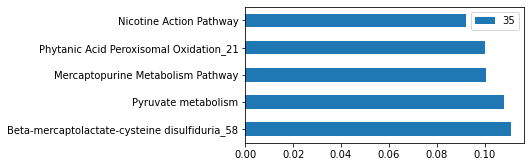

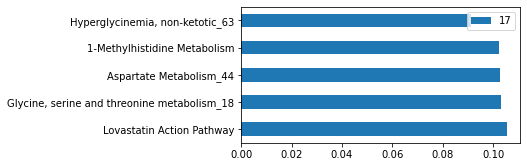

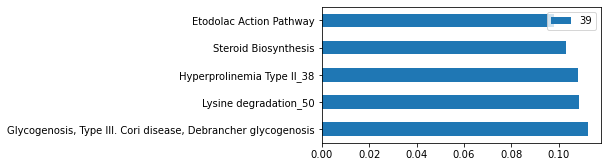

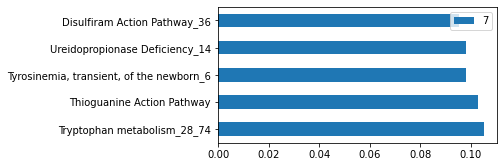

LVs associated with classification of slow progressors :
[37 38  6  9]
[-0.01563424, -0.0031181553, -0.0028201328, -0.0007618718]


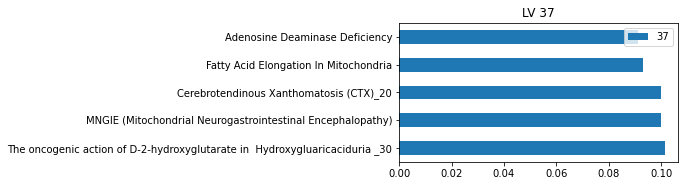

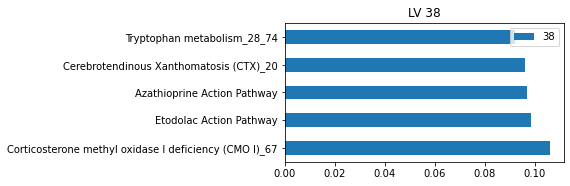

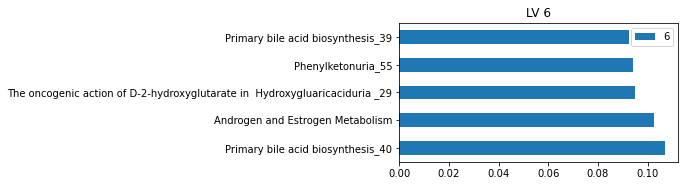

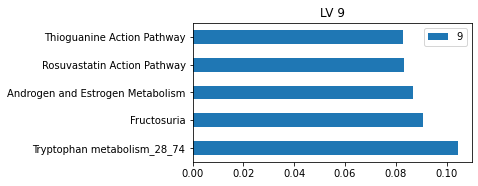

In [86]:
normomicro_model_unadj, Z_normomicro_unadj, y_normomicro_unadj = classify(model, Xtrain, Cmat, clinred_normomicro, clinadj=False)

## Top latent variables for predicting rapid eGFR decline with adjustment for clinical variables

8/8 [==============================] - 0s 961us/step


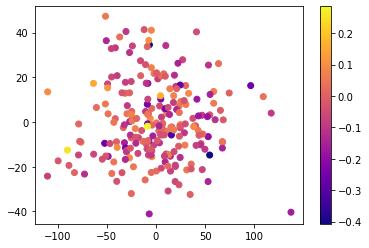

/Users/rabiul/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.943e-01, tolerance: 1.627e-04
  model = cd_fast.enet_coordinate_descent(
/Users/rabiul/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.874e-01, tolerance: 1.623e-04
  model = cd_fast.enet_coordinate_descent(
/Users/rabiul/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularis

Mean test scores:
[-0.10703423 -0.10650133 -0.10505123 -0.10316732 -0.10100512 -0.09813074
 -0.09596437 -0.09410978 -0.0932672  -0.0931797  -0.09280927 -0.0955564
 -0.09655328 -0.09694383 -0.09694383 -0.09694383 -0.09694383 -0.09694383
 -0.09694383]
Best alpha chosen:  0.02
final model score 0.11846669149274269
No LVs are associated with classification of rapid progressors!
LVs associated with classification of slow progressors :
[6 9]
[-0.0013231664548415281, -1.5672961492469188e-05]


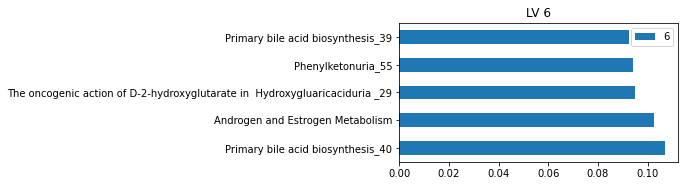

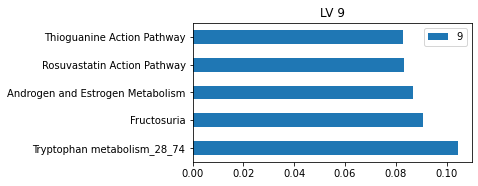

In [87]:
 normomicro_model, Z_normomicro, y_normomicro = classify(model, Xtrain, Cmat, clinred_normomicro, clinadj=True)

# Annotated Metabolites of APRT pathway

In [88]:
#get omics annotations
#print(anndf.columns)
#print(membdf.columns[0:10])
#print(Xtrain.columns[0:10])
#print(clindf.columns)

In [90]:
#find APRT pathway and ion numbers
aprt_ions = membdf.loc[membdf['Adenine.phosphoribosyltransferase.deficiency..APRT.']==1, 'ion']

#find aprt_ion names 
aprt_df = anndf.loc[anndf['ion'].astype(str).isin(aprt_ions), ['name', 'ion']]

display(aprt_df)



KeyError: 'Adenine.phosphoribosyltransferase.deficiency..APRT.'

In [91]:
#select metabos from Xtrain
Xtrain_sel = Xtrain.loc[:, Xtrain.columns.astype(str).isin(aprt_df.ion.astype(str))]
#Xtrain_sel.columns

NameError: name 'aprt_df' is not defined

In [92]:
#linear regression of APRT metabolites with eGFR rate
def metabo_classify(Xtrain, clin, clinadj=True, benchmark=False):
        
    #select Xtrain patients in the clinical variables
    X = Xtrain[Xtrain.index.isin(clin.index)]

    #drop duplicate patientids
    X = X[~X.index.duplicated(keep='first')]
 
    #get clinical variables for every patient in X
    clinx = clin.loc[X.index]

    #confirm equal number of samples
    assert(len(X.index)==len(clinx.index))
        
    #use mean eGFR rate as outcome
    y=clinx['mu_egfr_rate']
    
    #drop egfr rate in clinical variables
    clinx.drop(columns=['mu_egfr_rate'], inplace=True)
 
    #encode categorical sex clinical variable
    le = LabelEncoder()
    le.fit(clinx['sex_v3y0'].unique())
    clinx['sex_v3y0'] = le.transform(clinx['sex_v3y0'])

    #encode categorical race clinical variable
    le = LabelEncoder()
    le.fit(clinx['race_ethnicity_cat2_v3y0'].unique())
    clinx['race_ethnicity_cat2_v3y0'] = le.transform(clinx['race_ethnicity_cat2_v3y0'])

    #Z is training data
    Z = X
    
    #log and Zscore latent variables
    Z = np.log2(Z+1)
    Z = np.subtract(Z, np.mean(Z, axis=0))
    Z = np.divide(Z, np.std(Z, axis=0))

    #add clinical variables
    if clinadj:
        Z = Z.merge(clinx, on='patientid')
        
    #train clinical only model
    if benchmark:
        Z = clinx
    
    #guarantee column names are all strings
    Z.columns = Z.columns.astype(str)
    
    #Latent variable PCA represenation
    pca = PCA(n_components=2, random_state = seed)
    Z_pca = pca.fit_transform(Z)
    
    #visualize case/ctrl patients projected on first 2 prinicpal components
    fig = plt.figure()
    ax = fig.add_subplot()
    scatter = ax.scatter(Z_pca[:,0], Z_pca[:,1], c = y, cmap='plasma')
    fig.colorbar(scatter)
    # produce a legend with the unique colors from the scatter
    #legend1 = ax.legend(*scatter.legend_elements(), loc="upper right", title="fast progressors")
    #ax.add_artist(legend1)

    #ax.legend()
    plt.show()
    
    #grid search parameters
    PARAMETERS = {
        'alpha': [
        0.00001,
        0.00002,
        0.00005,
        0.0001,
        0.0002,
        0.0005,
        0.001,
        0.002,
        0.005,
        0.010,
        0.020,
        0.050,
        0.100,
        0.200,
        0.500,    
        1.000,
        2.000,
        5.000,    
        10.000,
        ]
    }
    MAX_ITER = 200000


    #define base model and how to gridsearch
    base_model = Lasso(max_iter=MAX_ITER, random_state=seed)
    clf = GridSearchCV(base_model, PARAMETERS, scoring='neg_root_mean_squared_error')

    #do gridsearch
    clf.fit(Z, y)
    best_params = max(
        zip(
            clf.cv_results_['param_alpha'], 
            clf.cv_results_['mean_test_score']
        ),
        key=lambda x: x[1]
    )
    best_alpha = best_params[0]
    #print('Mean test scores:')
    #print(clf.cv_results_['mean_test_score'])
    #print("Best alpha chosen: ", best_alpha)
    
    
    #Train final model with best hyperparameter
    final_model = Lasso(alpha=best_alpha, max_iter=MAX_ITER, random_state=seed)
    final_model.fit(Z, y)

    return final_model, Z, y

In [93]:
def metabo_weights(model, aprt_df):
    nmetabos = len(np.unique(aprt_df['ion']))
    #sort metabolites by coefficient
    sorted_idx = np.argsort(-np.square(model.coef_[0:nmetabos]))
    #create dataframe with ions and their names sorted by coefficient magnitude
    data = []
    for idx in sorted_idx:
        ion = model.feature_names_in_[idx]
        name = aprt_df.loc[aprt_df['ion'].astype(str) == ion].name.values[0]
        weight = model.coef_[idx]
        data.append([ion, name, weight])

    df = pd.DataFrame(data, columns=['ion', 'name', 'weight'])
    #display(df)
    return df

In [94]:
#Full cohort unadjusted
model2, Z, y = metabo_classify(Xtrain_sel, clinred_full, clinadj=False)
print('score', model2.score(Z, y))
df = metabo_weights(model2, aprt_df)
display(df)
df.to_csv('results/aprt_metabos_full_unadj.csv')

NameError: name 'Xtrain_sel' is not defined

In [95]:
#Full cohort adjusted
model2, Z, y = metabo_classify(Xtrain_sel, clinred_full, clinadj=True)
print('score', model2.score(Z, y))
df = metabo_weights(model2, aprt_df)
display(df)
df.to_csv('results/aprt_metabos_full_adjusted.csv')

NameError: name 'Xtrain_sel' is not defined

In [96]:
#normo unadjusted
model2, Z, y = metabo_classify(Xtrain_sel, clinred_normo, clinadj=False)
print('score', model2.score(Z, y))
df = metabo_weights(model2, aprt_df)
display(df)
df.to_csv('results/aprt_metabos_normo_unadj.csv')

NameError: name 'Xtrain_sel' is not defined

In [97]:
#normo adjusted
model2, Z, y = metabo_classify(Xtrain_sel, clinred_normo, clinadj=True)
print('score', model2.score(Z, y))
df = metabo_weights(model2, aprt_df)
display(df)
df.to_csv('results/aprt_metabos_normo_adjusted.csv')

NameError: name 'Xtrain_sel' is not defined

In [98]:
#normo-micro unadjusted
model2, Z, y = metabo_classify(Xtrain_sel, clinred_normomicro, clinadj=False)
print('score', model2.score(Z, y))
df = metabo_weights(model2, aprt_df)
display(df)
df.to_csv('results/aprt_metabos_normomicro_unadj.csv')

NameError: name 'Xtrain_sel' is not defined

In [99]:
#normo-micro adjusted
model2, Z, y = metabo_classify(Xtrain_sel, clinred_normomicro, clinadj=True)
print('score', model2.score(Z, y))
df = metabo_weights(model2, aprt_df)
display(df)
df.to_csv('results/aprt_metabos_normomicro_adjusted.csv')

NameError: name 'Xtrain_sel' is not defined

# Association of APRT pathway scores with composite renal outcome
We consider the composite event: Dialysis, Kidney Transplant, 50% eGFR decline, or eGFR<15 ml/min/1.73m^2. Two patient groups are split along the median APRT pathway score and the significance between the two survival curves is calculated. Finally, the prognostic strength of the binned High/Low category is quantified by C-statistic in a Cox proportional hazard model with adjustment for clinical variables. 

In [100]:
APRT_LV = '21'
pathwaydict = model.get_top_pathways([int(APRT_LV)], n_pathways=1)
df = pd.DataFrame(pathwaydict).fillna(0)

#print(df)
#print(df.index.values)

#assert we found where APRT pathway is 
assert(df.index.values[0]=='Adenine.phosphoribosyltransferase.deficiency..APRT.')

AssertionError: 

In [101]:
def setup_surv_analysis(APRT_values, clindf):

    # define events
    events = clindf['sa_allc_cric_renal3_v3y0']==1
    exit_times = clindf['sa_allc_cric_time_renal3_v3y0']

    #use only selected patients in APRT values
    events = events[events.index.isin(APRT_values.index)]
    exit_times = exit_times[exit_times.index.isin(APRT_values.index)]

    # Kaplan Meier Curve
    time, survival_prob = kaplan_meier_estimator(events, exit_times)
    plt.step(time, survival_prob, where="post")
    plt.title("Kaplan Mier curve for composite renal outcome")
    plt.ylabel("Event free probability")
    plt.xlabel("time $t$ in years")
    plt.show()
    
    return events, exit_times

In [102]:
#plot incidence rate and return stats
def analyse_incidence_rate(APRT_values, events, exit_times, quantile):

    #QC : default to 50 percentile if quanitle is not between 0 and 1.
    if quantile>=1 or quantile<=0:
        quantile=.5
    
    # partition treatment groups based on the median APRT_LV value
    #cutoff = np.median(APRT_values)
    cutoff = np.quantile(APRT_values, quantile)
    #cutoff = .60
    print("APRT cutoff value is " +str(cutoff))

    treatment_groups = pd.DataFrame()
    treatment_groups['High_APRT'] = APRT_values > cutoff
    treatment_groups['Low_APRT'] = APRT_values <= cutoff


    #select patients by record_id in the events data
    treatment_groups = treatment_groups[treatment_groups.index.isin(events.index)]
    #drop duplicate patientids
    treatment_groups = treatment_groups[~treatment_groups.index.duplicated(keep='first')]
    #get outcome for every patient in treatment_groups
    events = events.loc[treatment_groups.index]
    exit_times = exit_times.loc[treatment_groups.index]
    #confirm equal number of samples
    assert(len(events.index)==len(treatment_groups.index))
    #print(len(events.index))

    #Zip events and exit times into a list of tuples
    aux = list(zip(events, exit_times))
    # Structured array
    data_y = np.array(aux, dtype=[('Status', '?'), ('Survival_in_years', '<f8')])

    # group indicator
    group_indicator = pd.DataFrame(index=events.index)
    group_indicator['group'] = 'High_APRT'
    group_indicator.loc[treatment_groups['Low_APRT'],'group'] = 'Low_APRT'

    # compare survival curves
    chisq, pvalue, stats, covar = compare_survival(data_y, np.array(list(group_indicator['group'])), return_stats=True)
    #print(chisq)
    #print(pvalue)
    #print(covar)

    #compare High and Low APRT groups
    for group in list(group_indicator['group'].unique()):
        mask = np.array(group_indicator==group).squeeze()
        time_treatment, survival_prob_treatment = kaplan_meier_estimator(
            events[mask],
            exit_times[mask])

        plt.step(time_treatment, 1-survival_prob_treatment, where="post",
                 label="Treatment = %s" % group)

    plt.ylabel("Incidence Rate")
    plt.xlabel("time $t$ in years")
    plt.legend(loc="best")
    plt.annotate("p_value = "+str(round(pvalue, 5)), (4,.05))
    plt.show()
    
    return stats, group_indicator

In [103]:
def setup_CPH(X, group_indicator):
    #select patients in clin data that have assigned group indication
    data_x = X[X.index.isin(group_indicator.index)] 

    #merge APRT_LV predictor and clinical covariates
    data_x = data_x.join(group_indicator)

    #drop egfr rate as predictor
    data_x.drop(columns=['mu_egfr_rate'], inplace=True)

    #encode binary sex clinical variable
    if 'sex_v3y0' in data_x.columns:
        data_x['sex_v3y0'] = data_x['sex_v3y0'].astype('category')
        #le = LabelEncoder()
        #le.fit(data_x['sex_v3y0'].unique())
        #data_x['sex_v3y0'] = le.transform(data_x['sex_v3y0'])

    #encode categorical race clinical variable
    if 'race_ethnicity_cat2_v3y0' in data_x.columns:
        data_x['race_ethnicity_cat2_v3y0'] = data_x['race_ethnicity_cat2_v3y0'].astype('category')
        #le = OneHotEncoder()#LabelEncoder()
        #le.fit(data_x['race_ethnicity_cat2_v3y0'].unique())
        #data_x['race_ethnicity_cat2_v3y0'] = le.transform(data_x['race_ethnicity_cat2_v3y0'])

    #encode binary APART_LV group variable
    data_x['group'] = data_x['group'].astype('category')
    #le = LabelEncoder()
    #le.fit(data_x['group'].unique())
    #data_x['group'] = le.transform(data_x['group'])

    #encode categorical values
    from sksurv.preprocessing import OneHotEncoder
    data_x = OneHotEncoder().fit_transform(data_x)

    #Zip events and exit times into a list of tuples
    aux = list(zip(events, exit_times))
    # Structured array
    data_y = np.array(aux, dtype=[('Status', '?'), ('Survival_in_years', '<f8')])

    #display(data_x)
    
    return data_x, data_y

In [104]:
def setup_CPH_benchmark(X, group_indicator):
    #select patients in clin data that have assigned group indication
    data_x = X[X.index.isin(group_indicator.index)] 

    #merge APRT_LV predictor and clinical covariates
    #data_x = data_x.join(group_indicator)

    #drop egfr rate as predictor
    data_x.drop(columns=['mu_egfr_rate'], inplace=True)

    #encode binary sex clinical variable
    if 'sex_v3y0' in data_x.columns:
        data_x['sex_v3y0'] = data_x['sex_v3y0'].astype('category')
        #le = LabelEncoder()
        #le.fit(data_x['sex_v3y0'].unique())
        #data_x['sex_v3y0'] = le.transform(data_x['sex_v3y0'])

    #encode categorical race clinical variable
    if 'race_ethnicity_cat2_v3y0' in data_x.columns:
        data_x['race_ethnicity_cat2_v3y0'] = data_x['race_ethnicity_cat2_v3y0'].astype('category')
        #le = OneHotEncoder()#LabelEncoder()
        #le.fit(data_x['race_ethnicity_cat2_v3y0'].unique())
        #data_x['race_ethnicity_cat2_v3y0'] = le.transform(data_x['race_ethnicity_cat2_v3y0'])

    #encode binary APART_LV group variable
    #data_x['group'] = data_x['group'].astype('category')
    #le = LabelEncoder()
    #le.fit(data_x['group'].unique())
    #data_x['group'] = le.transform(data_x['group'])

    #encode categorical values
    from sksurv.preprocessing import OneHotEncoder
    data_x = OneHotEncoder().fit_transform(data_x)

    #Zip events and exit times into a list of tuples
    aux = list(zip(events, exit_times))
    # Structured array
    data_y = np.array(aux, dtype=[('Status', '?'), ('Survival_in_years', '<f8')])

    #display(data_x)
    
    return data_x, data_y

In [105]:
def setup_CPH_continuous(X, aprt_values):
    #select patients in clin data that have assigned group indication
    data_x = X[X.index.isin(aprt_values.index)] 

    #merge APRT_LV predictor and clinical covariates
    data_x = data_x.join(aprt_values)

    #drop egfr rate as predictor
    data_x.drop(columns=['mu_egfr_rate'], inplace=True)

    #encode binary sex clinical variable
    if 'sex_v3y0' in data_x.columns:
        data_x['sex_v3y0'] = data_x['sex_v3y0'].astype('category')
        #le = LabelEncoder()
        #le.fit(data_x['sex_v3y0'].unique())
        #data_x['sex_v3y0'] = le.transform(data_x['sex_v3y0'])

    #encode categorical race clinical variable
    if 'race_ethnicity_cat2_v3y0' in data_x.columns:
        data_x['race_ethnicity_cat2_v3y0'] = data_x['race_ethnicity_cat2_v3y0'].astype('category')
        #le = OneHotEncoder()#LabelEncoder()
        #le.fit(data_x['race_ethnicity_cat2_v3y0'].unique())
        #data_x['race_ethnicity_cat2_v3y0'] = le.transform(data_x['race_ethnicity_cat2_v3y0'])

    #encode categorical values
    from sksurv.preprocessing import OneHotEncoder
    data_x = OneHotEncoder().fit_transform(data_x)

    #Zip events and exit times into a list of tuples
    aux = list(zip(events, exit_times))
    # Structured array
    data_y = np.array(aux, dtype=[('Status', '?'), ('Survival_in_years', '<f8')])

    #display(data_x)
    
    return data_x, data_y

In [106]:
def cph_surv_analysis(data_x, data_y):

    #init and train proportional hazard model
    estimator = CoxPHSurvivalAnalysis()
    estimator.fit(data_x, data_y)

    #get C-statistic
    print("Concordance statistic: " + str(estimator.score(data_x, data_y)))

    # show coeffiecients, where each value corresponds to the log hazard ratio.
    lhr = pd.DataFrame(estimator.coef_, index=data_x.columns, columns=["log hazard ratio"])
    lhr = lhr.join(pd.DataFrame(np.exp(estimator.coef_), index=data_x.columns, columns=["hazard ratio"]))
    lhr =lhr.sort_values(by=['hazard ratio'], ascending=False)
    display(lhr)


## Full cohort analysis

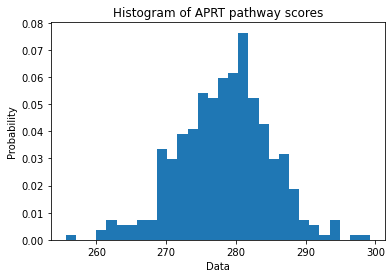

In [107]:
# partition APRT_LV value select patients by patient_id in the events data
APRT_values = Z_fullcohort.loc[Z_fullcohort.index.isin(clinred_full.index), APRT_LV]

plt.hist(APRT_values, density=True, bins=30)  # density=False would make counts
plt.title("Histogram of APRT pathway scores")
plt.ylabel('Probability')
plt.xlabel('Data');

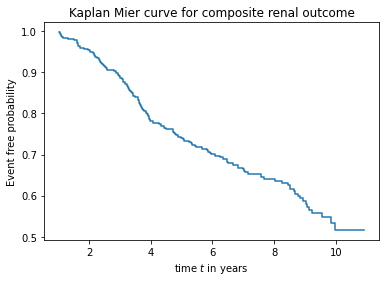

In [108]:
events, exit_times = setup_surv_analysis(APRT_values, clindf)

### Is there any difference in event probability between groups with high or low APRT pathway?

Patients are partitions at the median APRT pathway score into high_APRT and low_APRT groups and come survival curves

APRT cutoff value is 281.3638916015625


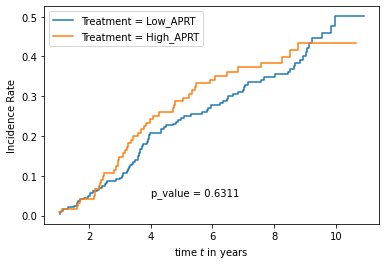

,counts,observed,expected,statistic
group,,,,
High_APRT,123,47,44.380674,2.619326
Low_APRT,246,88,90.619326,-2.619326


In [109]:
stats, group_indicator = analyse_incidence_rate(APRT_values, events, exit_times, quantile=APRT_quant)
display(stats)

### Cox Proportional Hazard

In [110]:
def fit_and_score_features(X, y):
    n_features = X.shape[1]
    scores = np.empty(n_features)
    m = CoxPHSurvivalAnalysis()
    for j in range(n_features):
        Xj = X[:, j:j+1]
        m.fit(Xj, y)
        scores[j] = m.score(Xj, y)
    return scores



In [111]:
data_x, data_y = setup_CPH_benchmark(clinred_full, group_indicator)
cph_surv_analysis(data_x, data_y)

Concordance statistic: 0.8653745568663915


/var/folders/p2/jrmg53fn5rzg_59yt1s7rm7h0000gn/T/ipykernel_81167/2089816472.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_x.drop(columns=['mu_egfr_rate'], inplace=True)
/var/folders/p2/jrmg53fn5rzg_59yt1s7rm7h0000gn/T/ipykernel_81167/2089816472.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_x['sex_v3y0'] = data_x['sex_v3y0'].astype('category')
/var/folders/p2/jrmg53fn5rzg_59yt1s7rm7h0000gn/T/ipykernel_81167/2089816472.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer

,log hazard ratio,hazard ratio
race_ethnicity_cat2_v3y0=4,1.232005,3.428097
race_ethnicity_cat2_v3y0=2,0.671010,1.956211
race_ethnicity_cat2_v3y0=3,0.646835,1.909487
log2acr,0.386373,1.471633
hemoglobin_a1c_v3y0,0.112753,1.119356
map_v3y0,0.009123,1.009164
age_integer_v3y0,-0.003890,0.996118
waist_v3y0,-0.005342,0.994672
egfr_cric_v3y0,-0.091077,0.912947
sex_v3y0=2,-0.204535,0.815026


In [112]:
scores = fit_and_score_features(data_x, data_y)
pd.Series(scores, index=data_x.columns).sort_values(ascending=False)

InvalidIndexError: (slice(None, None, None), slice(0, 1, None))

In [113]:
data_x, data_y = setup_CPH(clinred_full, group_indicator)
cph_surv_analysis(data_x, data_y)

Concordance statistic: 0.8658685418724937


,log hazard ratio,hazard ratio
race_ethnicity_cat2_v3y0=4,1.226764,3.410176
race_ethnicity_cat2_v3y0=3,0.685416,1.984598
race_ethnicity_cat2_v3y0=2,0.682639,1.979093
log2acr,0.382483,1.465921
hemoglobin_a1c_v3y0,0.111863,1.118360
map_v3y0,0.009212,1.009254
age_integer_v3y0,-0.004584,0.995426
waist_v3y0,-0.005086,0.994927
egfr_cric_v3y0,-0.091760,0.912324
group=Low_APRT,-0.105056,0.900274


In [114]:
data_x, data_y = setup_CPH_continuous(clinred_full, APRT_values)
cph_surv_analysis(data_x, data_y)

Concordance statistic: 0.8654617306909979


,log hazard ratio,hazard ratio
race_ethnicity_cat2_v3y0=4,1.230980,3.424584
race_ethnicity_cat2_v3y0=3,0.704344,2.022519
race_ethnicity_cat2_v3y0=2,0.687169,1.988079
log2acr,0.385122,1.469794
hemoglobin_a1c_v3y0,0.112453,1.119019
map_v3y0,0.008927,1.008967
21,0.002643,1.002646
age_integer_v3y0,-0.004247,0.995762
waist_v3y0,-0.005162,0.994851
egfr_cric_v3y0,-0.091179,0.912854


## Normo group analysis

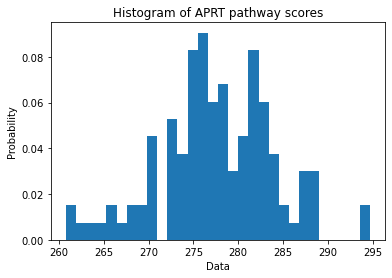

In [115]:
# partition APRT_LV value select patients by patient_id in the events data
APRT_values = Z_normo.loc[Z_normo.index.isin(clinred_normo.index), APRT_LV]

plt.hist(APRT_values, density=True, bins=30)  # density=False would make counts
plt.title("Histogram of APRT pathway scores")
plt.ylabel('Probability')
plt.xlabel('Data');

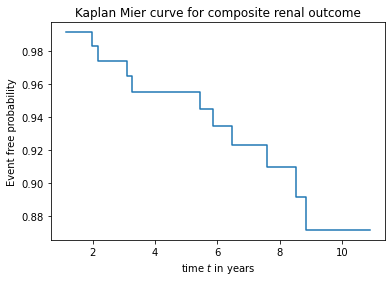

In [116]:
events, exit_times = setup_surv_analysis(APRT_values, clindf)

### Is there any difference in event probability between groups with high or low APRT pathway?

Patients are partitions at the median APRT pathway score into high_APRT and low_APRT groups and come survival curves

APRT cutoff value is 280.7274678548177


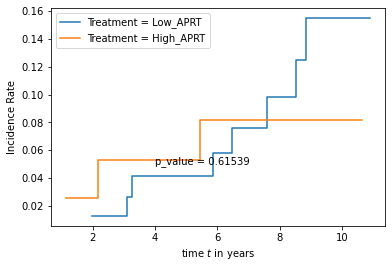

,counts,observed,expected,statistic
group,,,,
High_APRT,39,3,3.791235,-0.791235
Low_APRT,78,8,7.208765,0.791235


In [117]:
stats, group_indicator = analyse_incidence_rate(APRT_values, events, exit_times, quantile=APRT_quant)
display(stats)

### Cox Proportional Hazard

In [118]:
data_x, data_y = setup_CPH_benchmark(clinred_normo, group_indicator)
cph_surv_analysis(data_x, data_y)

Concordance statistic: 0.9234746639089969


/var/folders/p2/jrmg53fn5rzg_59yt1s7rm7h0000gn/T/ipykernel_81167/2089816472.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_x.drop(columns=['mu_egfr_rate'], inplace=True)
/var/folders/p2/jrmg53fn5rzg_59yt1s7rm7h0000gn/T/ipykernel_81167/2089816472.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_x['sex_v3y0'] = data_x['sex_v3y0'].astype('category')
/var/folders/p2/jrmg53fn5rzg_59yt1s7rm7h0000gn/T/ipykernel_81167/2089816472.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer

,log hazard ratio,hazard ratio
sex_v3y0=2,1.514982,4.549339
hemoglobin_a1c_v3y0,0.403741,1.497417
age_integer_v3y0,0.052008,1.053384
log2acr,0.038265,1.039007
map_v3y0,0.032287,1.032814
waist_v3y0,-0.044280,0.956686
egfr_cric_v3y0,-0.231023,0.793722
race_ethnicity_cat2_v3y0=4,-1.611483,0.199591
race_ethnicity_cat2_v3y0=2,-1.785938,0.167640


In [119]:
data_x, data_y = setup_CPH(clinred_normo, group_indicator)
cph_surv_analysis(data_x, data_y)

Concordance statistic: 0.9317476732161324


,log hazard ratio,hazard ratio
sex_v3y0=2,1.274880,3.578273
group=Low_APRT,1.164482,3.204262
hemoglobin_a1c_v3y0,0.350453,1.419710
log2acr,0.151178,1.163204
map_v3y0,0.033742,1.034317
age_integer_v3y0,0.028743,1.029160
waist_v3y0,-0.061468,0.940383
egfr_cric_v3y0,-0.231140,0.793628
race_ethnicity_cat2_v3y0=2,-2.185586,0.112412
race_ethnicity_cat2_v3y0=4,-2.285742,0.101699


## Normo+micro group analysis

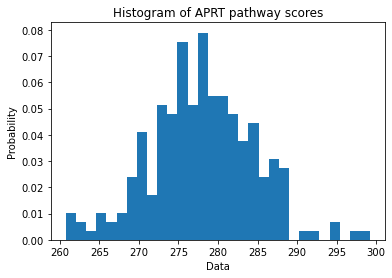

In [120]:
# partition APRT_LV value select patients by patient_id in the events data
APRT_values = Z_normomicro.loc[Z_normomicro.index.isin(clinred_normomicro.index), APRT_LV]

plt.hist(APRT_values, density=True, bins=30)  # density=False would make counts
plt.title("Histogram of APRT pathway scores")
plt.ylabel('Probability')
plt.xlabel('Data');

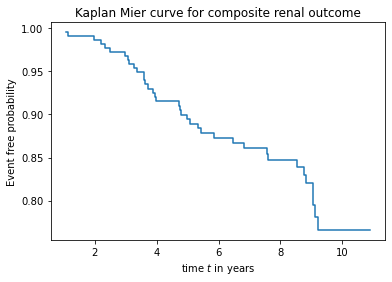

In [121]:
events, exit_times = setup_surv_analysis(APRT_values, clindf)

### Is there any difference in event probability between groups with high or low APRT pathway?

Patients are partitions at the median APRT pathway score into high_APRT and low_APRT groups and come survival curves

APRT cutoff value is 280.66546630859375


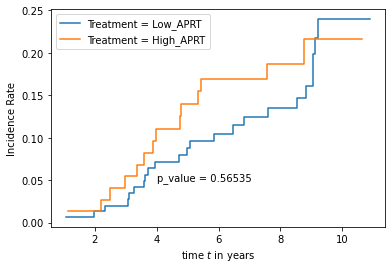

,counts,observed,expected,statistic
group,,,,
High_APRT,76,14,12.352285,1.647715
Low_APRT,151,23,24.647715,-1.647715


In [122]:
stats, group_indicator = analyse_incidence_rate(APRT_values, events, exit_times, quantile=APRT_quant)
display(stats)

### Cox Proportional Hazard

In [123]:
data_x, data_y = setup_CPH(clinred_normomicro, group_indicator)
cph_surv_analysis(data_x, data_y)

Concordance statistic: 0.883410290237467


,log hazard ratio,hazard ratio
log2acr,0.237783,1.268433
sex_v3y0=2,0.231510,1.260502
hemoglobin_a1c_v3y0,0.114372,1.121169
age_integer_v3y0,0.096497,1.101307
map_v3y0,0.031420,1.031919
waist_v3y0,-0.012853,0.987229
group=Low_APRT,-0.155573,0.855925
egfr_cric_v3y0,-0.159221,0.852808
race_ethnicity_cat2_v3y0=2,-0.163745,0.848958
race_ethnicity_cat2_v3y0=4,-0.300509,0.740441


In [124]:
data_x, data_y = setup_CPH_benchmark(clinred_normomicro, group_indicator)
cph_surv_analysis(data_x, data_y)

Concordance statistic: 0.8817612137203166


/var/folders/p2/jrmg53fn5rzg_59yt1s7rm7h0000gn/T/ipykernel_81167/2089816472.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_x.drop(columns=['mu_egfr_rate'], inplace=True)
/var/folders/p2/jrmg53fn5rzg_59yt1s7rm7h0000gn/T/ipykernel_81167/2089816472.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_x['sex_v3y0'] = data_x['sex_v3y0'].astype('category')
/var/folders/p2/jrmg53fn5rzg_59yt1s7rm7h0000gn/T/ipykernel_81167/2089816472.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer

,log hazard ratio,hazard ratio
sex_v3y0=2,0.256944,1.292973
log2acr,0.243715,1.275980
hemoglobin_a1c_v3y0,0.113372,1.120049
age_integer_v3y0,0.096618,1.101440
map_v3y0,0.031544,1.032047
waist_v3y0,-0.014055,0.986043
egfr_cric_v3y0,-0.159792,0.852321
race_ethnicity_cat2_v3y0=2,-0.214550,0.806904
race_ethnicity_cat2_v3y0=4,-0.392075,0.675654
race_ethnicity_cat2_v3y0=3,-12.263458,0.000005


# Association of Abacavir action pathway scores with composite renal outcome
We consider the composite event: Dialysis, Kidney Transplant, 50% eGFR decline, or eGFR<15 ml/min/1.73m^2. Two patient groups are split along the median APRT pathway score and the significance between the two survival curves is calculated. Finally, the prognostic strength of the binned High/Low category is quantified by C-statistic in a Cox proportional hazard model with adjustment for clinical variables. 

In [125]:
APRT_LV = '0'
pathwaydict = model.get_top_pathways([int(APRT_LV)], n_pathways=1)
df = pd.DataFrame(pathwaydict).fillna(0)

#print(df)
#print(df.index.values)

#assert we found where abacavir action pathway is 
assert(df.index.values[0]=='Abacavir.Action.Pathway')

AssertionError: 

In [126]:
def setup_surv_analysis(APRT_values, clindf):

    # define events
    events = clindf['sa_allc_cric_renal3_v3y0']==1
    exit_times = clindf['sa_allc_cric_time_renal3_v3y0']

    #use only selected patients in APRT values
    events = events[events.index.isin(APRT_values.index)]
    exit_times = exit_times[exit_times.index.isin(APRT_values.index)]

    # Kaplan Meier Curve
    time, survival_prob = kaplan_meier_estimator(events, exit_times)
    plt.step(time, survival_prob, where="post")
    plt.title("Kaplan Mier curve for composite renal outcome")
    plt.ylabel("Event free probability")
    plt.xlabel("time $t$ in years")
    plt.show()
    
    return events, exit_times

In [127]:
#plot incidence rate and return stats
def analyse_incidence_rate(APRT_values, events, exit_times, quantile):

    #QC : default to 50 percentile if quanitle is not between 0 and 1.
    if quantile>=1 or quantile<=0:
        quantile=.5
    
    # partition treatment groups based on the median APRT_LV value
    #cutoff = np.median(APRT_values)
    cutoff = np.quantile(APRT_values, quantile)
    #cutoff = .60
    print("APRT cutoff value is " +str(cutoff))

    treatment_groups = pd.DataFrame()
    treatment_groups['High_APRT'] = APRT_values > cutoff
    treatment_groups['Low_APRT'] = APRT_values <= cutoff


    #select patients by record_id in the events data
    treatment_groups = treatment_groups[treatment_groups.index.isin(events.index)]
    #drop duplicate patientids
    treatment_groups = treatment_groups[~treatment_groups.index.duplicated(keep='first')]
    #get outcome for every patient in treatment_groups
    events = events.loc[treatment_groups.index]
    exit_times = exit_times.loc[treatment_groups.index]
    #confirm equal number of samples
    assert(len(events.index)==len(treatment_groups.index))
    #print(len(events.index))

    #Zip events and exit times into a list of tuples
    aux = list(zip(events, exit_times))
    # Structured array
    data_y = np.array(aux, dtype=[('Status', '?'), ('Survival_in_years', '<f8')])

    # group indicator
    group_indicator = pd.DataFrame(index=events.index)
    group_indicator['group'] = 'High_APRT'
    group_indicator.loc[treatment_groups['Low_APRT'],'group'] = 'Low_APRT'

    # compare survival curves
    chisq, pvalue, stats, covar = compare_survival(data_y, np.array(list(group_indicator['group'])), return_stats=True)
    #print(chisq)
    #print(pvalue)
    #print(covar)

    #compare High and Low APRT groups
    for group in list(group_indicator['group'].unique()):
        mask = np.array(group_indicator==group).squeeze()
        time_treatment, survival_prob_treatment = kaplan_meier_estimator(
            events[mask],
            exit_times[mask])

        plt.step(time_treatment, 1-survival_prob_treatment, where="post",
                 label="Treatment = %s" % group)

    plt.ylabel("Incidence Rate")
    plt.xlabel("time $t$ in years")
    plt.legend(loc="best")
    plt.annotate("p_value = "+str(round(pvalue, 5)), (4,.05))
    plt.show()
    
    return stats, group_indicator

In [128]:
def setup_CPH(X, group_indicator):
    #select patients in clin data that have assigned group indication
    data_x = X[X.index.isin(group_indicator.index)] 

    #merge APRT_LV predictor and clinical covariates
    data_x = data_x.join(group_indicator)

    #drop egfr rate as predictor
    data_x.drop(columns=['mu_egfr_rate'], inplace=True)

    #encode binary sex clinical variable
    if 'sex_v3y0' in data_x.columns:
        data_x['sex_v3y0'] = data_x['sex_v3y0'].astype('category')
        #le = LabelEncoder()
        #le.fit(data_x['sex_v3y0'].unique())
        #data_x['sex_v3y0'] = le.transform(data_x['sex_v3y0'])

    #encode categorical race clinical variable
    if 'race_ethnicity_cat2_v3y0' in data_x.columns:
        data_x['race_ethnicity_cat2_v3y0'] = data_x['race_ethnicity_cat2_v3y0'].astype('category')
        #le = OneHotEncoder()#LabelEncoder()
        #le.fit(data_x['race_ethnicity_cat2_v3y0'].unique())
        #data_x['race_ethnicity_cat2_v3y0'] = le.transform(data_x['race_ethnicity_cat2_v3y0'])

    #encode binary APART_LV group variable
    data_x['group'] = data_x['group'].astype('category')
    #le = LabelEncoder()
    #le.fit(data_x['group'].unique())
    #data_x['group'] = le.transform(data_x['group'])

    #encode categorical values
    from sksurv.preprocessing import OneHotEncoder
    data_x = OneHotEncoder().fit_transform(data_x)

    #Zip events and exit times into a list of tuples
    aux = list(zip(events, exit_times))
    # Structured array
    data_y = np.array(aux, dtype=[('Status', '?'), ('Survival_in_years', '<f8')])

    #display(data_x)
    
    return data_x, data_y

In [129]:
def cph_surv_analysis(data_x, data_y):
    from sksurv.linear_model import CoxPHSurvivalAnalysis

    #init and train proportional hazard model
    estimator = CoxPHSurvivalAnalysis()
    estimator.fit(data_x, data_y)

    #get C-statistic
    print("Concordance statistic: " + str(estimator.score(data_x, data_y)))

    # show coeffiecients, where each value corresponds to the log hazard ratio.
    lhr = pd.DataFrame(estimator.coef_, index=data_x.columns, columns=["log hazard ratio"])
    lhr = lhr.join(pd.DataFrame(np.exp(estimator.coef_), index=data_x.columns, columns=["hazard ratio"]))
    lhr =lhr.sort_values(by=['hazard ratio'], ascending=False)
    display(lhr)


## Full cohort analysis

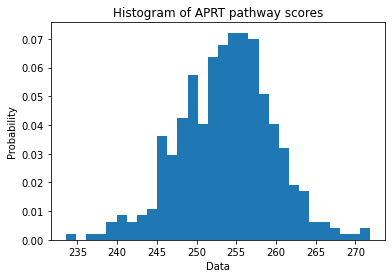

In [130]:
# partition APRT_LV value select patients by patient_id in the events data
APRT_values = Z_fullcohort.loc[Z_fullcohort.index.isin(clinred_full.index), APRT_LV]

plt.hist(APRT_values, density=True, bins=30)  # density=False would make counts
plt.title("Histogram of APRT pathway scores")
plt.ylabel('Probability')
plt.xlabel('Data');

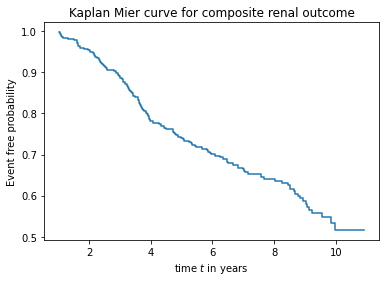

In [131]:
events, exit_times = setup_surv_analysis(APRT_values, clindf)

### Is there any difference in event probability between groups with high or low APRT pathway?

Patients are partitions at the median APRT pathway score into high_APRT and low_APRT groups and come survival curves

APRT cutoff value is 256.3028055826823


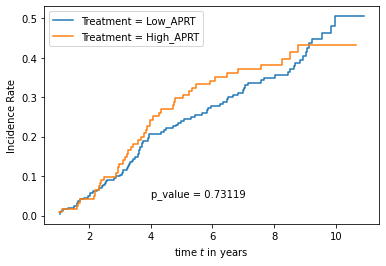

,counts,observed,expected,statistic
group,,,,
High_APRT,123,47,45.117924,1.882076
Low_APRT,246,88,89.882076,-1.882076


In [132]:
stats, group_indicator = analyse_incidence_rate(APRT_values, events, exit_times, quantile=APRT_quant)
display(stats)

### Cox Proportional Hazard

In [133]:
data_x, data_y = setup_CPH(clinred_full, group_indicator)
cph_surv_analysis(data_x, data_y)

Concordance statistic: 0.8657523101063521


,log hazard ratio,hazard ratio
race_ethnicity_cat2_v3y0=4,1.225146,3.404662
race_ethnicity_cat2_v3y0=3,0.688332,1.990392
race_ethnicity_cat2_v3y0=2,0.682869,1.979548
log2acr,0.382447,1.465867
hemoglobin_a1c_v3y0,0.111387,1.117827
map_v3y0,0.009280,1.009323
age_integer_v3y0,-0.004508,0.995502
waist_v3y0,-0.005172,0.994842
egfr_cric_v3y0,-0.091927,0.912172
group=Low_APRT,-0.112477,0.893618


## Normo group analysis

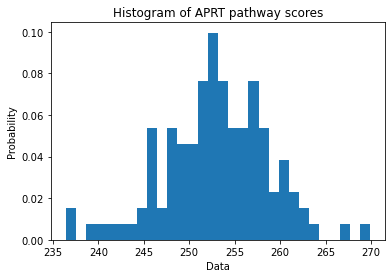

In [134]:
# partition APRT_LV value select patients by patient_id in the events data
APRT_values = Z_normo.loc[Z_normo.index.isin(clinred_normo.index), APRT_LV]

plt.hist(APRT_values, density=True, bins=30)  # density=False would make counts
plt.title("Histogram of APRT pathway scores")
plt.ylabel('Probability')
plt.xlabel('Data');

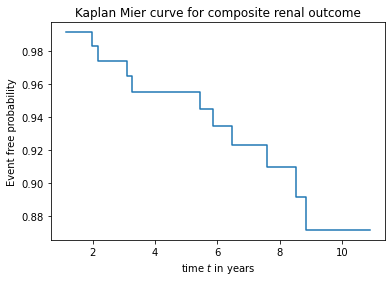

In [135]:
events, exit_times = setup_surv_analysis(APRT_values, clindf)

### Is there any difference in event probability between groups with high or low APRT pathway?

Patients are partitions at the median APRT pathway score into high_APRT and low_APRT groups and come survival curves

APRT cutoff value is 255.63553873697916


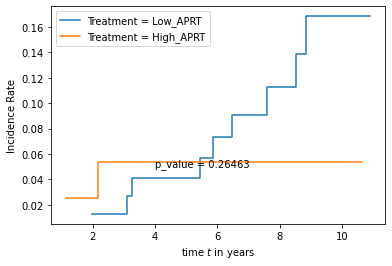

,counts,observed,expected,statistic
group,,,,
High_APRT,39,2,3.752235,-1.752235
Low_APRT,78,9,7.247765,1.752235


In [136]:
stats, group_indicator = analyse_incidence_rate(APRT_values, events, exit_times, quantile=APRT_quant)
display(stats)

### Cox Proportional Hazard

In [137]:
data_x, data_y = setup_CPH(clinred_normo, group_indicator)
cph_surv_analysis(data_x, data_y)

Concordance statistic: 0.9400206825232679


,log hazard ratio,hazard ratio
group=Low_APRT,1.185050,3.270849
sex_v3y0=2,1.015987,2.762089
hemoglobin_a1c_v3y0,0.276619,1.318664
log2acr,0.074543,1.077392
age_integer_v3y0,0.067152,1.069458
map_v3y0,0.029958,1.030411
waist_v3y0,-0.059212,0.942507
egfr_cric_v3y0,-0.228235,0.795938
race_ethnicity_cat2_v3y0=2,-2.016707,0.133093
race_ethnicity_cat2_v3y0=4,-2.314315,0.098834


## Normo+micro group analysis

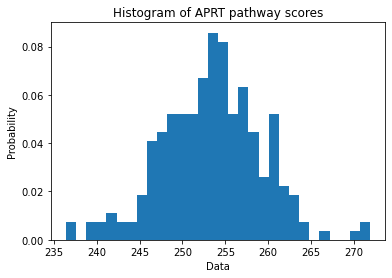

In [138]:
# partition APRT_LV value select patients by patient_id in the events data
APRT_values = Z_normomicro.loc[Z_normomicro.index.isin(clinred_normomicro.index), APRT_LV]

plt.hist(APRT_values, density=True, bins=30)  # density=False would make counts
plt.title("Histogram of APRT pathway scores")
plt.ylabel('Probability')
plt.xlabel('Data');

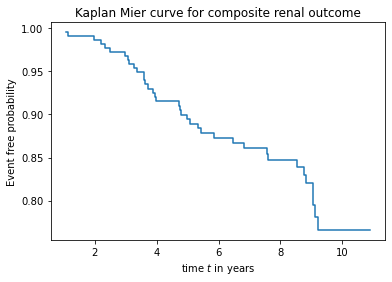

In [139]:
events, exit_times = setup_surv_analysis(APRT_values, clindf)

### Is there any difference in event probability between groups with high or low APRT pathway?

Patients are partitions at the median APRT pathway score into high_APRT and low_APRT groups and come survival curves

APRT cutoff value is 255.67406209309897


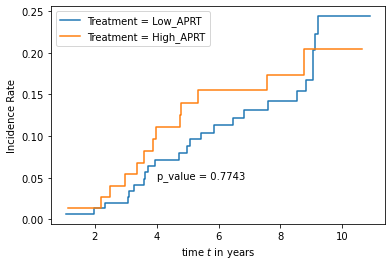

,counts,observed,expected,statistic
group,,,,
High_APRT,76,13,12.181322,0.818678
Low_APRT,151,24,24.818678,-0.818678


In [140]:
stats, group_indicator = analyse_incidence_rate(APRT_values, events, exit_times, quantile=APRT_quant)
display(stats)

### Cox Proportional Hazard

In [141]:
data_x, data_y = setup_CPH(clinred_normomicro, group_indicator)
cph_surv_analysis(data_x, data_y)

Concordance statistic: 0.8814313984168866


,log hazard ratio,hazard ratio
sex_v3y0=2,0.252376,1.287080
log2acr,0.241669,1.273372
hemoglobin_a1c_v3y0,0.113838,1.120571
age_integer_v3y0,0.095924,1.100675
map_v3y0,0.031530,1.032033
waist_v3y0,-0.013607,0.986485
group=Low_APRT,-0.062171,0.939722
egfr_cric_v3y0,-0.159520,0.852553
race_ethnicity_cat2_v3y0=2,-0.195010,0.822827
race_ethnicity_cat2_v3y0=4,-0.355871,0.700563
